In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from pathlib import Path
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Extra functions for lr_find
class ParameterModule(nn.Module):
    "Register a lone parameter 'p' in a module"
    def __init__(self, p:nn.Parameter):
        super().__init__()
        self.val = p
    def forward(self, x): return x

def children_and_parameters(m:nn.Module):
    "Return the children of `m` and its direct parameters not registered in modules."
    children = list(m.children())
    children_p = sum([[id(p) for p in c.parameters()] for c in m.children()],[])
    for p in m.parameters():
        if id(p) not in children_p: children.append(ParameterModule(p))
    return children

flatten_model = lambda m: sum(map(flatten_model,children_and_parameters(m)),[]) if len(list(m.children())) else [m]

# lr_range
def lr_range(model, lr):
    """
    Build differential learning rate from lr
    Arguments:
        lr :- float or slice
        num_layer :- number of layers with requires_grad=True
    Returns:
        Depending upon lr
    """
    if not isinstance(lr, slice): 
        return lr
    
    num_layer = [nn.Sequential(*flatten_model(model))]
    if lr.start: 
        mult = lr.stop / lr.start
        step = mult**(1/(num_layer-1))
        res = np.array([lr.start*(step**i) for i in range(num_layer)])
    else:
        res = [lr.stop/10]*(num_layer-1) + [lr.stop]
    
    return np.array(res)

In [102]:
def annealing_no(start, end, pct:float):
    "No annealing, always return `start`."
    return start
def annealing_linear(start, end, pct:float):
    "Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start + pct * (end-start)
def annealing_exp(start, end, pct:float):
    "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start * (end/start) ** pct
def annealing_cos(start, end, pct:float):
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out
def do_annealing_poly(start, end, pct:float, degree):
    return end + (start-end) * (1-pct)**degree

class Stepper():
    "Used to \"step\" from start, end ('vals') over 'n_iter' iterations on a schedule"
    def __init__(self, vals, n_iter:int, func=None):
        self.start, self.end = (vals[0], vals[1]) if isinstance(vals, tuple) else (vals,0)
        self.n_iter = max(1, n_iter)
        if func is None:
            self.func = annealing_linear if isinstance(vals, tuple) else annealing_no
        else:
            self.func = func
        self.n = 0
    
    def step(self):
        "Return next value along annealed schedule"
        self.n += 1
        return self.func(self.start, self.end, self.n/self.n_iter)
        
    @property
    def is_done(self)->bool:
        "Return 'True' if schedule completed"
        return self.n >= self.n_iter

class SmoothenValue():
    "Create a smooth moving average for a value (loss, etc) using `beta`."
    def __init__(self, beta:float):
        self.beta,self.n,self.mov_avg = beta,0,0
    def add_value(self, val:float)->None:
        "Add `val` to calculate updated smoothed value."
        self.n += 1
        self.mov_avg = self.beta * self.mov_avg + (1 - self.beta) * val
        self.smooth = self.mov_avg / (1 - self.beta ** self.n)
    
def LRFinder(model, 
             data, 
             loss_fn, 
             opt, 
             wd:int=0, 
             start_lr:float=1e-7, 
             end_lr:float=10, 
             num_it:int=100, 
             stop_div:bool=True,
             smooth_beta:float=0.98):
    model.train()
    
    stop = False
    best_loss = 0.
    flag = False
    losses = []
    iteration = 0
    lrs = []
    lrs.append(start_lr)
    
    start_lr = lr_range(model, start_lr)
    start_lr = np.array(start_lr) if isinstance(start_lr, (tuple, list)) else start_lr
    end_lr = lr_range(model, end_lr)
    end_lr = np.array(end_lr) if isinstance(end_lr, (tuple, list)) else end_lr
    
    sched = Stepper((start_lr, end_lr), num_it, annealing_exp)
    opt.lr = sched.start
    smoothener = SmoothenValue(smooth_beta)
    
    # save model_dict
    model_state = model.state_dict()
    opt_state = opt.state_dict()

    epochs = int(np.ceil(num_it/len(data)))
    
    for i in range(epochs):
        for dat in data:
            # Batch begin
            inputs, labels = dat
            opt.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
#             losses.append(loss.detach())
            # On batch_begin
            smoothener.add_value(loss.detach())
            smooth_loss = smoothener.smooth
            losses.append(smooth_loss)
            loss.backward()
            
#             For adamW
            for group in opt.param_groups:
                for param in group['params']:
                    param.data = param.data.add(-wd * group['lr'], param.data)
                    
            opt.step()
            
            # Change lr
            new_lr = sched.step()
            lrs.append(new_lr)
            for i, param_group in enumerate(opt.param_groups):
                param_group['lr'] = new_lr
                
            if iteration == 0 or smooth_loss < best_loss:
                best_loss = smooth_loss
            iteration += 1
            
            if sched.is_done or (stop_div and (smooth_loss > 4*best_loss or torch.isnan(loss))):
                flag = True
                break
            
            print('Iteration: ', iteration)
            
        if flag:
            break
    
    # Load state back
    model.load_state_dict(model_state)
    opt.load_state_dict(opt_state)
    
    print('LR Finder is complete')
    
    lrs.pop()
    return losses, lrs

def plot_lr_finder(losses, 
                   lrs, 
                   skip_start:int=10, 
                   skip_end:int=5, 
                   suggestion:bool=False, 
                   return_fig:bool=None): 
#                    smoothen_by_spline:bool=True):
    lrs = lrs[skip_start:-skip_end] if skip_end > 0 else lrs[skip_start:]
    losses = losses[skip_start:-skip_end] if skip_end > 0 else losses[skip_start:]
    losses = [x.item() for x in losses]
#     if smoothen_by_spline:
#         xs = np.arange(len(losses))
#         spl = UnivariateSpline(xs, losses, k=1)
#         losses = spl(xs)
        
    fig, ax = plt.subplots(1, 1)
    ax.plot(lrs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
    
    if suggestion:
        try:
            mg = (np.gradient(np.array(losses))).argmin()
        except:
            print("Failed to compute the gradients, there might not be enough points.")
            return
        print(f"Min numerical gradient: {lrs[mg]:.2E}")
        ax.plot(lrs[mg], losses[mg], markersize=10, marker='o', color='red')
    
    if return_fig is not None:
        return fig

In [93]:
path = '../../../Data/cifar10/train/'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder(path, transform=transform)

data = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)

In [94]:
model = torchvision.models.resnet18()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))

In [95]:
losses, lrs = LRFinder(model, data, criterion, optim)

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Iteration:  67
Iter

Min numerical gradient: 1.20E-03


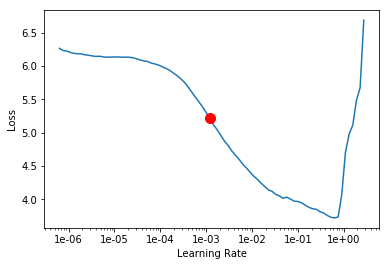

In [104]:
plot_lr_finder(losses, lrs, suggestion=True)

In [ ]:
# fit_one_cycle
def fit_one_cycle(model,
                  data,
                  loss_fn,
                  opt,
                  cyc_len:int,
                  tot_epochs:int,
                  max_lr=0.001,
                  moms=(0.95, 0.85),
                  pct_start:float=0.3
                  div_factor:float=25,
                  final_div:float=None,
                  wd:float=None,
                  start_epoch:int=0):
    """
    Fit model with one cycle policy
    """
    max_lr = lr_range(model, max_lr)
    if final_div is None: final_div = div_factor*qe4
    if isinstance(max_lr, (tuple, list)): max_lr = np.array(max_lr)
    
    # train begin
    # Initialize optimization params based on annealing schedule
    res = {'epoch': start_epoch} if start_epoch is not None else None
    n = len(data) * tot_epochs
    a1 = int(n*pct_start)
    a2 = n - a1
    phases = ((a1, annealing_cos), (a2, annealing_cos))
    low_lr = lr_max / div_factor
    def steps(*steps_cfg):
        return [Stepper(step, n_iter, func=func) for (step, (n_iter,func)) in zip(steps_cfg, phases)]
    lr_scheds = steps((low_lr,lr_max), (lr_max, lr_max/final_div))
    mom_scheds = steps(moms, (moms[1], moms[0]))
    opt.lr = lr_scheds[0].start
    opt.mom = mom_scheds[0].start

In [123]:
optim = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
for group in optim.param_groups:
    print(group)
    break

In [129]:
optim_adam = torch.optim.Adam(model.parameters(), lr=0.001)

In [130]:
optim_adam.lr = 0.001

In [132]:
optim_adam.mom = 0.001

In [133]:
optim_adam.mom

0.001